# 📊 Evaluation & Visualization - AG News (FLAN-T5) - Fixed Version

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from tqdm import tqdm
import re
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model loaded on {device}")


Model loaded on cpu


In [2]:
dataset = load_dataset("ag_news")
labels_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

def load_prompt_template(path, template_number=1):
    with open(path, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Match "Template {number}: ..." and capture until the next "Template" or EOF
    pattern = rf"Template {template_number}:(.*?)(?:Template \d+:|$)"
    match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)
    
    if not match:
        raise ValueError(f"❌ Template {template_number} not found")
    
    raw_prompt = match.group(1).strip()
    
    # Remove leading/trailing ======= and comments
    cleaned_lines = [
        line for line in raw_prompt.splitlines()
        if line.strip() and not line.strip().startswith("#") and not line.strip().startswith("=")
    ]
    
    return "\n".join(cleaned_lines).strip()

# Load prompt template
prompt_template = load_prompt_template(r"c:\Users\pnsri\Documents\Zoro_Innovations\Project-2\zero-short-text-classification\prompts\ag_news\ag_prompt_templates.txt", template_number=1)
print("✅ Extracted Prompt Template:\n", prompt_template)

def generate_prompt(text):
    return prompt_template.replace("{news_article}", text)

def flan_predict(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=10)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


✅ Extracted Prompt Template:
 Direct Classification Style
Classify the following news article into one of these categories: World, Sports, Business, or Science/Technology.
Article: "{news_article}"
Respond with exactly one word: World, Sports, Business, or Science/Technology.
Answer:


In [ ]:
test_data = dataset["test"].select(range(100))  # Process 500 samples
predictions = []

print("🚀 Starting predictions...")
for row in tqdm(test_data):
    text = row["text"]
    true_label = row["label"]
    
    prompt = generate_prompt(text)
    output = flan_predict(prompt)
    
    # Clean and normalize prediction
    response = output.strip().lower()
    
    # Clean multiline output
    lines = [line.strip() for line in response.splitlines() if line.strip()]
    if lines:
        response = lines[-1]
    
    # Remove punctuation
    response = response.replace(".", "").replace(":", "").strip()
    
    # Normalize prediction based on AG News categories
    pred = "Unknown"
    if "world" in response:
        pred = "World"
    elif "sports" in response or "sport" in response:
        pred = "Sports"
    elif "business" in response:
        pred = "Business"
    elif "sci" in response or "tech" in response or "science" in response or "technology" in response:
        pred = "Sci/Tech"
    
    predictions.append({
        "text": text,
        "true_label": labels_map[true_label],
        "prediction": pred
    })

# Create DataFrame and save predictions
result_df = pd.DataFrame(predictions)
print(f"Total predictions: {len(result_df)}")

# Save predictions CSV
predictions_file = r"c:\Users\pnsri\Documents\Zoro_Innovations\Project-2\zero-short-text-classification\outputs\ag_news\ag_news_predictions.csv"
result_df.to_csv(predictions_file, index=False)
print(f"✅ Predictions saved to {predictions_file}")




🚀 Starting predictions...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]

Total predictions: 100
✅ Predictions saved to c:\Users\pnsri\Documents\Zoro_Innovations\Project-2\zero-short-text-classification\outputs\ag_news\ag_news_predictions.csv



📊 Metrics:
Accuracy: 0.8500
Precision: 0.8386
Recall: 0.8798
F1 Score: 0.8357
✅ Metrics saved to ../outputs/ag_news/metrics.csv


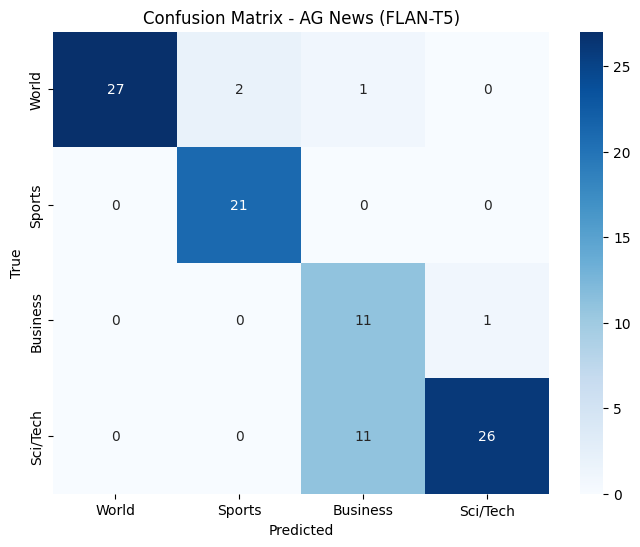

✅ Confusion matrix saved to ../outputs/ag_news/agnews_confusion_matrix.png

🎉 AG News classification completed!


In [7]:
filtered_df = result_df[result_df["prediction"] != "Unknown"]
if len(filtered_df) > 0:
    acc = accuracy_score(filtered_df["true_label"], filtered_df["prediction"])
    precision, recall, f1, _ = precision_recall_fscore_support(
        filtered_df["true_label"], filtered_df["prediction"], 
        average="macro", zero_division=0
    )
    
    print(f"\n📊 Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Save metrics to CSV
    metrics_file = "../outputs/ag_news/metrics.csv"
    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Value": [acc, precision, recall, f1]
    })
    metrics_df.to_csv(metrics_file, index=False)
    print(f"✅ Metrics saved to {metrics_file}")
    
    # Create confusion matrix
    cm = confusion_matrix(
        filtered_df["true_label"], 
        filtered_df["prediction"], 
        labels=list(labels_map.values())
    )
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_map.values(),
                yticklabels=labels_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - AG News (FLAN-T5)")
    
    confusion_matrix_file = "../outputs/ag_news/agnews_confusion_matrix.png"
    plt.savefig(confusion_matrix_file)
    plt.show()
    print(f"✅ Confusion matrix saved to {confusion_matrix_file}")

else:
    print("❌ No valid predictions found for metrics calculation")

print("\n🎉 AG News classification completed!")